# Иследование бизнес показателей

Мы - мобильная утилита для сканирования документов. 

Модель монетизации подписочная:
 - пробныей период 7 дней
 - далее 4,99 USD в неделю

Имеется выгрузка с базы данных по оформлению подписок и оплат. Каждая строка представляет собой отдельное событие (либо оформление пробной подписки, либо оплата после завершения пробного периода). имеются следующие задания:

 1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций).
 2. Спрогнозировать, каким будет LTV на полгода.
 3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.
 4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

## Импорт данных и библиотек 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
import lifetimes

In [2]:
df = pd.read_excel('/Users/Lenovo/Downloads/test case data analyst.xlsx', sheet_name='raw data')
df

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657
...,...,...,...,...,...
114195,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8291100
114196,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936
114197,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910
114198,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146


Вижу что в выгрузке 5 столбцов:
 - наименование продукта
 - кол-во продукта
 - пробный период это или нет
 - дата оплаты
 - номер клиента

## Предподготовка данных

Гляну на данные, а именно посмотрю на пропуски, дубликаты, и типы данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


пропусков нет, типы данных в порядке, гляну на дубликаты

In [6]:
df.duplicated().value_counts()

False    114116
True         84
dtype: int64

обнаружил 84 дубликата, гляну на них

In [7]:
df.value_counts().head(20)

product_id                               quantity  is_trial_period  purchase_date  user_id
1week_4.99_USD_subscription_7days_trial  1         False            2020-02-16     9584301    7
                                                   True             2020-01-05     8364086    3
                                                                    2020-01-19     8805046    3
                                                                    2020-01-26     9004386    3
                                                                    2020-01-09     8486473    3
                                                                    2020-02-13     9527949    3
                                                                    2020-01-18     8752195    3
                                                                    2020-02-07     9363812    3
                                                                    2020-01-08     8450482    3
                                             

вижу что в выгрузке есть странные дубликаты, один из клиентов одновременно купил подписку 7 раз за день, а есть такие которые за день 3 раза начали использовать наше приложение в триал версии

Количество дубликатов и их нелогичная приророда наводит на мысль что это ошибка при формировании выгрузки, я в любом случае доведу информацию о наличии дубликатов в выгрузке руководителю, возможно ошибка формируется раньше.

Удалю дубликаты

In [3]:
df = df.drop_duplicates()
df

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657
...,...,...,...,...,...
114195,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8291100
114196,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936
114197,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910
114198,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146


дубликаты удалил, ровно 84 строки, меньше 1 % от наших данных

гляну на временной период и уникальное кол-во пользователей

In [4]:
date_start = df['purchase_date'].min()
date_end = df['purchase_date'].max()
total_customer = df['user_id'].nunique()

print(f'Временной период с {date_start} по {date_end}')
print('Уникальных пользователей:', total_customer)
print()

Временной период с 2020-01-01 00:00:00 по 2020-02-20 00:00:00
Уникальных пользователей: 62909



**ВЫВОД**
 - данные даны с 01.01.2020 по 20.02.2022
 - количество уникальных пользователей в выборке 62 909 пользователей
 - в выбоке 84 дубликаты, были удалены
 - осталось 114116 строк
 - пропусков в датасете нет
 - данные изначально были приведены в нужный формат

##  Иследование данных

### Общее иследование 

гляну как распределяются события в течении данного периода

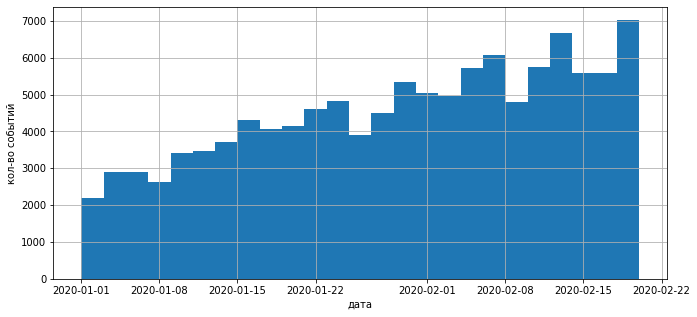

In [5]:
df['purchase_date'].hist(bins = 25, figsize = (11,5))
plt.xlabel('дата')
plt.ylabel('кол-во событий')
plt.show()

по данной гистограмме вижу, что  в даной выгрузке наблюдается растущий тренд в кол-ве событий, чуть позже гляну подробнее

А сейчас посмотрю сколько продуктов и какое количество есть в датасете

In [6]:
print(df['product_id'].unique())
print(df['quantity'].unique())

['1week_4.99_USD_subscription_7days_trial']
[1]


вижу что в данной выгрузке только один продукт, наша подписка, и кол-во ее всегда равно единице


### Расчитаю LTV применяя когортный анализ

Для начала найду даты первого посещения по каждому посетителю, т.е кагорту и проверю коректность понедельного лайфтайм каждой когорты

In [7]:
first_purchase = (
    df
    .query('is_trial_period == True')
    .groupby('user_id')
    .agg({'purchase_date':'min'})
) # сгрупировал данные по первому триал пользованию

first_purchase.columns = ['first_purchase_date'] # перемеиновал столбец

df_cohorts = df.merge(first_purchase, on= 'user_id') # cоединил с основной таблицей

df_cohorts['purchase_week'] = df_cohorts['purchase_date'].astype('datetime64[W]') #получил неделю конкретного события
df_cohorts['first_purchase_week'] = df_cohorts['first_purchase_date'].astype('datetime64[W]') # получил недельные когорты 

df_cohorts['cohort_lifetime'] = ((
    df_cohorts['purchase_week'] - df_cohorts['first_purchase_week']) 
    / np.timedelta64(1, 'W')).round().astype('int') # получил лайфтайм кокогт


display(df_cohorts.head())
df_cohorts.info()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_purchase_date,purchase_week,first_purchase_week,cohort_lifetime
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06,1
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222,2020-02-12,2020-02-06,2020-02-06,0
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06,1
3,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9422402,2020-02-10,2020-02-06,2020-02-06,0
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 114116 entries, 0 to 114115
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   product_id           114116 non-null  object        
 1   quantity             114116 non-null  int64         
 2   is_trial_period      114116 non-null  bool          
 3   purchase_date        114116 non-null  datetime64[ns]
 4   user_id              114116 non-null  int64         
 5   first_purchase_date  114116 non-null  datetime64[ns]
 6   purchase_week        114116 non-null  datetime64[ns]
 7   first_purchase_week  114116 non-null  datetime64[ns]
 8   cohort_lifetime      114116 non-null  int32         
dtypes: bool(1), datetime64[ns](4), int32(1), int64(2), object(1)
memory usage: 7.5+ MB


Когорты получены, пропусков нет

Проверю есть ли отрицательные лайфтайм

In [8]:
df_cohorts[df_cohorts['cohort_lifetime'] < 0]

,product_id,quantity,is_trial_period,purchase_date,user_id,first_purchase_date,purchase_week,first_purchase_week,cohort_lifetime
15024,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-22,1511831,2020-01-31,2020-01-16,2020-01-30,-2
15025,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-01,1511831,2020-01-31,2019-12-26,2020-01-30,-5
15026,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-08,1511831,2020-01-31,2020-01-02,2020-01-30,-4
15027,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-29,1511831,2020-01-31,2020-01-23,2020-01-30,-1
15029,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-15,1511831,2020-01-31,2020-01-09,2020-01-30,-3
29016,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-03,7591159,2020-02-02,2020-01-02,2020-01-30,-4
29017,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-10,7591159,2020-02-02,2020-01-09,2020-01-30,-3
51438,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-14,2555928,2020-01-22,2020-01-09,2020-01-16,-1
51439,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-07,2555928,2020-01-22,2020-01-02,2020-01-16,-2
58798,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-04,7204327,2020-01-12,2020-01-02,2020-01-09,-1


У меня появились операции с минусовым лайфтайм, вижу что у этих 6 пользователей по каким то причинам начался триал период позже платного,  так не должно быть, возможно сбой нашего приложения, или сбой при выгрузе, снова донесу информацию до руководства, а эти записи уберу из нашей выгрузки, но перед эти гляну на разницу в днях, возможно таких записей больше

In [9]:
 days_diff = ((
    df_cohorts['purchase_date'] - df_cohorts['first_purchase_date']) 
    / np.timedelta64(1, 'D')).round().astype('int').reset_index()
    
len(days_diff[days_diff[0] < 0])

16

таких записей 16, удалю их всех из нашего датасета

In [10]:
drop_line= days_diff[days_diff[0] < 0]['index']

df_cohorts = df_cohorts.drop(index=drop_line.index)
df_cohorts

,product_id,quantity,is_trial_period,purchase_date,user_id,first_purchase_date,purchase_week,first_purchase_week,cohort_lifetime
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06,1
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222,2020-02-12,2020-02-06,2020-02-06,0
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06,1
3,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9422402,2020-02-10,2020-02-06,2020-02-06,0
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06,1
...,...,...,...,...,...,...,...,...,...
114111,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8243299,2020-01-03,2020-01-02,2020-01-02,0
114112,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936,2020-01-02,2020-01-02,2020-01-02,0
114113,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910,2020-01-03,2020-01-02,2020-01-02,0
114114,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146,2020-01-04,2020-01-02,2020-01-02,0


удалил события с минусовым лайф таймом

Теперь доблю стоимость подписки, где триал доступ, укажу ноль доларов, где не триал 5,99 доларов

In [11]:
df_cohorts['price'] = 0
df_cohorts.loc[df_cohorts['is_trial_period']==False,"price"] += 4.99

df_cohorts.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_purchase_date,purchase_week,first_purchase_week,cohort_lifetime,price
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06,1,4.99
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222,2020-02-12,2020-02-06,2020-02-06,0,0.00
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06,1,4.99
3,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9422402,2020-02-10,2020-02-06,2020-02-06,0,0.00
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06,1,4.99


Cгрупирую данные по когортам, получу LTV и сделаю сводную таблицу с накоплением LTV по неделям, построю визуализацию

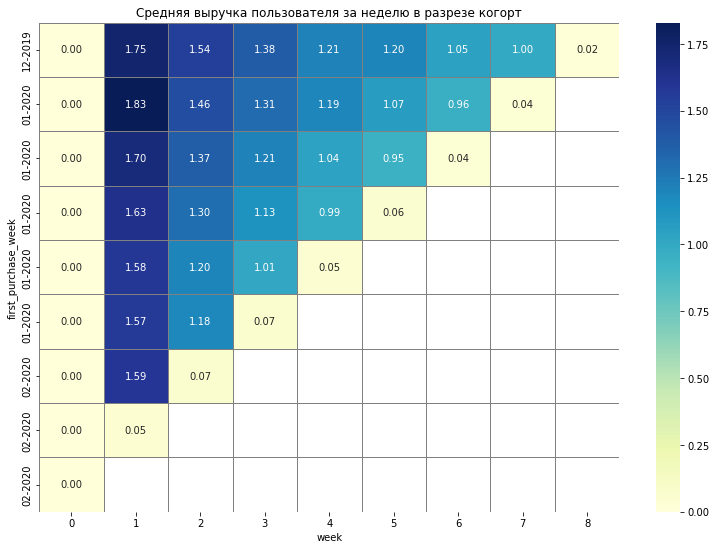

In [12]:
cohort_sizes = (
    df_cohorts.groupby('first_purchase_week')
    .agg({'user_id': 'nunique'})
    .reset_index() 
) #получил когорты с количеством уникальных пользователей

cohort_sizes.columns = ['first_purchase_week', 'n_buyers'] #перемеиновал столбцы

cohorts = (
    df_cohorts.groupby(['first_purchase_week', 'purchase_week'])
    .agg({'price': 'sum'})
    .reset_index() 
)# получил когорты с выручкой

report = pd.merge(cohort_sizes, cohorts, on='first_purchase_week') # соединил выручки и количество клиентом

report['week'] = ((
    report['purchase_week'] - report['first_purchase_week']
) / np.timedelta64(1, 'W')).round().astype('int') #получил lifetime когорт


report['ltv'] = report['price'] / report['n_buyers'] #получил ltv

output = (
    report
    .pivot_table(index='first_purchase_week', 
                 columns='week', 
                 values='ltv', 
                 aggfunc='mean')
    .round(2)
    #.cumsum(axis = 1) #сводная таблица
)

plt.figure(figsize=(13, 9))
plt.title('Средняя выручка пользователя за неделю в разрезе когорт')
sns.heatmap(output, 
            annot=True,
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu", 
            yticklabels= output.index.strftime('%m-%Y'))
plt.show()


In [13]:
ltv_mean_six_month = output.cumsum(axis = 1).iloc[0:4, 5].mean().round(2)
print('Средняя LTV за 6 недель по когортам прожившие 6 или более недель:', ltv_mean_six_month, '$') 

Средняя LTV за 6 недель по когортам прожившие 6 или более недель: 6.33 $


на визуализации вижу что с каждой кагортой, выручка становится все меньше и меньше, гляну как какогты уменьшаются в постоянных пользователях

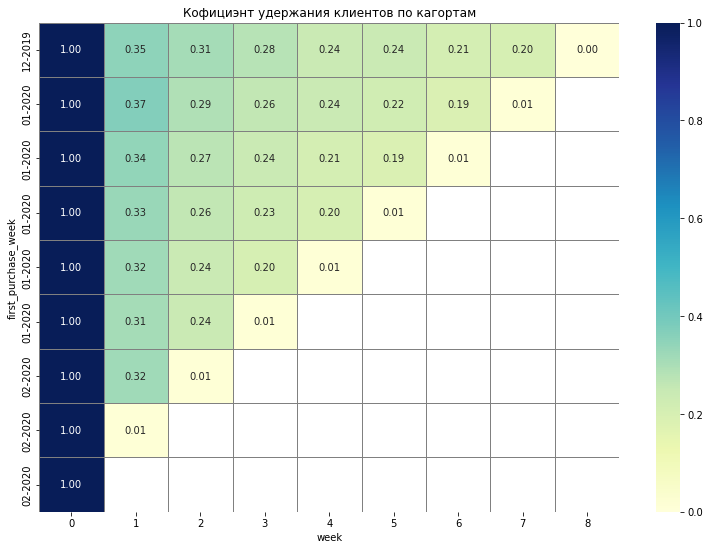

In [15]:

cohorts_1 = (
    df_cohorts.groupby(['first_purchase_week', 'purchase_week'])
    .agg({'user_id': 'nunique'})
    .reset_index() 
)# получил когорты с уникальными юзерами

report_1 = pd.merge(cohort_sizes, cohorts_1, on='first_purchase_week') # соединил выручки и количество клиентом

report_1['week'] = ((
    report_1['purchase_week'] - report_1['first_purchase_week']
) / np.timedelta64(1, 'W')).round().astype('int') #получил lifetime когорт


report_1['rr'] = report_1['user_id'] / report_1['n_buyers'] #получил rr

output_1 = (
    report_1
    .pivot_table(index='first_purchase_week', 
                 columns='week', 
                 values='rr', 
                 aggfunc='mean')
    .round(2)
     #сводная таблица
)

plt.figure(figsize=(13, 9))
plt.title('Кофициэнт удержания клиентов по кагортам')
sns.heatmap(output_1, 
            annot=True,
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray', 
            cmap="YlGnBu", 
            yticklabels= output.index.strftime('%m-%Y'))
plt.show()


Вижу что к четвертой недели почти 80 % пользователей отваливаются

### Спрогназирую LTV на пол года

воспользуюсь BG/NBD моделью, для этого сначало подготовлю сводную таблицу из данных 

In [17]:
summary = lifetimes.utils.summary_data_from_transaction_data(df_cohorts, 'user_id', 'purchase_date', 'price').reset_index()
summary.head()

,user_id,frequency,recency,T,monetary_value
0,404,1.0,7.0,17.0,4.99
1,5337,0.0,0.0,3.0,0.00
2,9010,3.0,21.0,24.0,4.99
3,19880,0.0,0.0,21.0,0.00
4,23403,3.0,22.0,31.0,4.99


где:
 - frequency — количество повторных покупок (более 1 покупки)
 - recency — время между первой и последней оплатой
 - T — время между первой покупкой и окончанием периода оплат
 - monetary_value — это средняя стоимость покупки
 
 Гляну как распределяется пользователи по частоте покупок

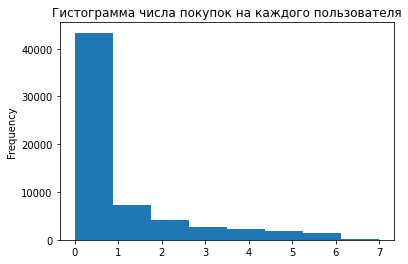

Число пользователей, которые не совершили ни одной покупки: 68.89%


In [18]:
summary['frequency'].plot(kind='hist',bins=8)
plt.title('Гистограмма числа покупок на каждого пользователя')
plt.show()
one_time_buyers = sum(summary ['frequency'] == 0) / len(summary)
print(('Число пользователей, которые не совершили ни одной покупки: {:.2%}').format(one_time_buyers))

Большая часть пользователей ни разу не купила у нас подписку

Теперь применю модель BG/NBD с целью предсказанию будущих покупок к сводным данным

In [19]:
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.09)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 62909 subjects, a: 0.00, alpha: 10.22, b: 0.00, r: 0.32>

In [73]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.187349e-01,3.232707e-03,3.123988e-01,3.250710e-01
alpha,1.000994e+01,1.270139e-01,9.760991e+00,1.025889e+01
a,1.787266e-16,6.005155e-12,-1.176992e-11,1.177028e-11
b,1.879389e-07,6.313712e-03,-1.237469e-02,1.237506e-02


Модель получил, теперь выделю повторных клиентов и применю модель Gamma-Gamma для расчета стоимость покупок

In [20]:
return_user_summary = summary[summary['frequency'] > 0]
print(return_user_summary.shape)
return_user_summary = return_user_summary[return_user_summary['monetary_value'] > 0]
return_user_summary.head()

(19569, 5)


,user_id,frequency,recency,T,monetary_value
0,404,1.0,7.0,17.0,4.99
2,9010,3.0,21.0,24.0,4.99
4,23403,3.0,22.0,31.0,4.99
5,23647,3.0,21.0,28.0,4.99
7,33989,3.0,21.0,24.0,4.99


In [21]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_user_summary['frequency'], return_user_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 19542 subjects, p: 10.85, q: 11.68, v: 5.33>

In [22]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,10.852444,0.09786,10.660639,11.044250
q,11.682680,0.09975,11.487169,11.878190
v,5.330552,0.05642,5.219969,5.441136


теперь я могу предсказать ltv

In [23]:

summary['predicted_ltv'] = ggf.customer_lifetime_value(bgf,
                                                      summary['frequency'],
                                                      summary['recency'],
                                                      summary['T'],
                                                      summary['monetary_value'],
                                                      time = 6, # месяцы
                                                      freq = 'D', #у меня данные в дня 
                                                      discount_rate = 0.8) #по причине большого оттока пользователей указываю 80 %
summary.head()

,user_id,frequency,recency,T,monetary_value,predicted_ltv
0,404,1.0,7.0,17.0,4.99,9.211879
1,5337,0.0,0.0,3.0,0.00,NaN
2,9010,3.0,21.0,24.0,4.99,18.016225
3,19880,0.0,0.0,21.0,0.00,NaN
4,23403,3.0,22.0,31.0,4.99,14.956879


Предсказание готово, гляну на него

In [24]:
summary['predicted_ltv'].describe()

count    20856.000000
mean        12.695540
std          5.900418
min          1.062740
25%          8.031716
50%         13.045689
75%         18.016225
max         23.617537
Name: predicted_ltv, dtype: float64

кажется очень похоже на реальный, сравню его с реальным

### График реального и спрогназируемого LTV

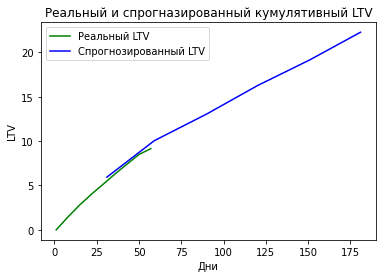

In [25]:
ltv_pre = summary['predicted_ltv'].quantile([0.165, 0.33, 0.495, 0.66, 0.825, 0.99 ])
days_month = [31, 59, 90, 120, 151, 181]

ltv = output.cumsum(axis = 1).mean(axis = 0)
days_week = [1, 8, 15, 22, 29, 36, 43, 50, 57]# так ка первая неделя заканчивается первым января то и отщет беру от него



fig, ax = plt.subplots()
ax.plot(days_week, ltv, color = 'green', label='Реальный LTV')
ax.plot(days_month, ltv_pre, color = 'blue', label='Спрогнозированный LTV')
plt.title('Реальный и спрогназированный кумулятивный LTV')
ax.legend(loc = 'upper left')
plt.xlabel('Дни')
plt.ylabel('LTV')
plt.show()

Спрогнозированный LTV очень похож на реальный, не смотря на то что зеленная линия реального в конце отклоняется ниже, нужно учитывать что в этот временной промежуток я имею моала данных

### Расчет ROMI на 4 недели и 6 месяцев

Перед тем как расчитать romi только с клиентами которые заплатили мне нужно пересчитать реальный и прогнозируемый LTV 

In [34]:
df_cohorts_2 = df_cohorts[df_cohorts['cohort_lifetime'] != 0]
df_cohorts_2

cohort_sizes_2 = (
    df_cohorts_2.groupby('first_purchase_week')
    .agg({'user_id': 'nunique'})
    .reset_index() 
) #получил когорты с количеством уникальных пользователей

cohort_sizes_2.columns = ['first_purchase_week', 'n_buyers'] #перемеиновал столбцы

cohorts_2 = (
    df_cohorts_2.groupby(['first_purchase_week', 'purchase_week'])
    .agg({'price': 'sum'})
    .reset_index() 
)# получил когорты с выручкой

report_2 = pd.merge(cohort_sizes_2, cohorts_2, on='first_purchase_week') # соединил выручки и количество клиентом

report_2['week'] = ((
    report_2['purchase_week'] - report_2['first_purchase_week']
) / np.timedelta64(1, 'W')).round().astype('int') #получил lifetime когорт


report_2['ltv'] = report_2['price'] / report_2['n_buyers'] #получил ltv

output_2 = (
    report_2
    .pivot_table(index='first_purchase_week', 
                 columns='week', 
                 values='ltv', 
                 aggfunc='mean')
    .round(2)    
)

summary_2 = lifetimes.utils.summary_data_from_transaction_data(df_cohorts_2, 'user_id', 'purchase_date', 'price').reset_index()
bgf_2 = lifetimes.BetaGeoFitter(penalizer_coef=0.09)
bgf_2.fit(summary_2['frequency'], summary_2['recency'], summary_2['T'])
ggf_2 = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
return_user_summary_2 = summary_2[summary_2['frequency'] > 0]
ggf_2.fit(return_user_summary['frequency'], return_user_summary['monetary_value'])
summary_2['predicted_ltv'] = ggf.customer_lifetime_value(bgf,
                                                      summary_2['frequency'],
                                                      summary_2['recency'],
                                                      summary_2['T'],
                                                      summary_2['monetary_value'],
                                                      time = 6, # месяцы
                                                      freq = 'D', #у меня данные в дня 
                                                      discount_rate = 0.2) #по причине большого оттока пользователей указываю 80 %

,user_id,frequency,recency,T,monetary_value,predicted_ltv
0,404,1.0,7.0,17.0,4.99,9.211879
1,5337,0.0,0.0,3.0,0.00,NaN
2,9010,3.0,21.0,24.0,4.99,18.016225
3,19880,0.0,0.0,21.0,0.00,NaN
4,23403,3.0,22.0,31.0,4.99,14.956879


In [ ]:
Зафиксирую что CAC на одного платящего пользователя 6 USD.

и получу ROMi за 4 недели и 6 месяцев

In [37]:
cac = 6


print('За 4 недели ROMI равно: {} %'.format(((output_2.cumsum(axis = 1).mean(axis=0)[4] - cac) / cac * 100).round(2)))
print('За пол года ROMI равно: {} %'.format(((summary_2['predicted_ltv'].mean() - cac) / cac * 100).round(2)))

За 4 недели ROMI равно: 124.8 %
За пол года ROMI равно: 559.49 %


## Вывод

1. Средняя LTV за 6 недель по когортам прожившие 6 или более недель: 6.33 $
2. наблюдается снижение ltv как по когортам так и в течении их жизни
3. почти 80 % пользователей отваливаются к 4 недели
4. За 4 недели ROMI равно: 124.8 %
5. За пол года ROMI равно: 559.49 %